# 🧬 Controllable Enhancer Sequence Generation

This notebook demonstrates how to use **NTv3** as a diffusion-based model for generating *de novo* enhancer sequences with controllable activity levels.

> 📝 **Note for Google Colab users:** This notebook is compatible with Colab! For faster generation, enable GPU: Runtime → Change runtime type → GPU (T4 or better recommended). 

## 📋 Overview

NTv uses **Masked Diffusion Language Modeling (MDLM)** to generate enhancer sequences conditioned on:
- **Promoter context** (DSCP or RpS12 backbone)
- **Activity level** (bins 0-4, from lowest to highest)

The model supports **Classifier-Free Guidance (CFG)** to enhance conditioning strength and enable promoter-specific enhancer design.

## 📚 Notebook Structure

1. **Setup**: Install dependencies and load the model from HuggingFace
2. **Generation Functions**: MDLM sampling with Classifier-Free Guidance
3. **Experiment 1**: Generate enhancers conditioned on activity levels
4. **Experiment 2**: Generate promoter-specific enhancers
5. **Evaluation**: Validate generated sequences with DeepSTARR oracle model

## 💻 Hardware Requirements

This pipeline uses batch size designed for limited resources (e.g., GoogleColab with T4 GPU). However, it would take relatively long time for the generation (~30h per experiment on a single T4 GPU). The outputs shown here was obtained on a more powerful setup and shown as reference. For efficient generation, we recommend using GPUs like A100 (~40min with current batch size) and a larger batch size during generation. 
> 📝 **Note for Google Colab users:** This notebook is compatible with Colab! Enable GPU for faster training: Runtime → Change runtime type → GPU (T4 or better recommended). 
> If generation is taking too long/too much GPU RAM, consider reducing the amount of sequence generated per experiment.

## 0) 📦 Setup


In [ ]:
import json
import os
from typing import Any, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from huggingface_hub import login, hf_hub_download
from torch.distributions import Categorical
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer
login()

In [ ]:
# Load NTv3 generative model from HuggingFace
repo_id = "InstaDeepAI/NTv3_generative"

tokenizer = AutoTokenizer.from_pretrained(repo_id, trust_remote_code=True)
model = AutoModel.from_pretrained(repo_id, trust_remote_code=True)
model.eval()

print(f"Model loaded from {repo_id}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

## 1) 🔧 Generation Functions

NTv3-Generative uses the **Masked Diffusion Language Model (MDLM)** framework to generate enhancer sequences. The generation process works as follows:

1. **Initialize with masked tokens**: Start with a promoter backbone sequence where the enhancer region is fully masked
2. **Iterative denoising**: Gradually unmask tokens over multiple diffusion steps, sampling from the posterior distribution
3. **Conditioning**: Use species and activity labels to guide generation toward desired properties

### 🎯 Classifier-Free Guidance (CFG)

CFG allows generating enhancers with specific properties by combining logits from two contexts:

$$\text{logits}_{\text{combined}} = (1 - \gamma) \cdot \text{logits}_{\text{background}} + \gamma \cdot \text{logits}_{\text{experiment}}$$

> 💡 **Tip:** Setting $\gamma > 1$ pushes the generation toward the experiment condition. Higher values produce stronger conditioning but may reduce diversity.

In [ ]:
# Load backbone metadata (promoter sequences with enhancer insertion sites)
backbone_path = hf_hub_download(
    repo_id="InstaDeepAI/NTv3_enhancer_generation",
    filename="backbones/backbone_metadata.json",
    repo_type="dataset",
)
with open(backbone_path, "r") as f:
    backbone_metadata = json.load(f)

print(f"Available promoters: {list(backbone_metadata['promoters'].keys())}")


In [5]:
# =============================================================================
# MDLM Sampling and Generation Functions
# =============================================================================

def mdlm_sample(
    tokens: torch.Tensor,
    logits: torch.Tensor,
    t: float,
    dt: float,
    mask_token_id: int,
    valid_token_ids: Optional[List[int]] = None,
) -> torch.Tensor:
    """
    Sample from MDLM posterior distribution.

    Args:
        tokens: (B, L) current tokens
        logits: (B, L, V) model logits
        t: current time step (1 -> 0)
        dt: time step size
        mask_token_id: ID of mask token
        valid_token_ids: list of valid token IDs to sample from (e.g., A, C, G, T)

    Returns:
        (B, L) sampled tokens
    """
    # Linear noise schedule: noise_level = t
    noise_t = t
    noise_s = max(t - dt, 0)
    signal_t = 1.0 - noise_t
    signal_s = 1.0 - noise_s

    # Mask invalid tokens if specified
    if valid_token_ids is not None:
        mask = torch.full_like(logits, float('-inf'))
        mask[..., valid_token_ids] = logits[..., valid_token_ids]
        logits = mask

    # Convert logits to probabilities
    probs = F.softmax(logits, dim=-1)

    # Compute posterior for masked positions
    # masked_posterior = probs * (signal_s - signal_t) / (1 - signal_t) + mask_prob
    masked_posterior = probs * (signal_s - signal_t) / (1 - signal_t + 1e-8)
    masked_posterior[..., mask_token_id] = (1 - signal_s) / (1 - signal_t + 1e-8)

    # Copy-over for unmasked positions (keep original token)
    unmasked_posterior = F.one_hot(tokens, logits.shape[-1]).float()

    # Combine: use masked_posterior where token is mask, else unmasked_posterior
    posterior = torch.where(
        tokens[..., None] == mask_token_id,
        masked_posterior,
        unmasked_posterior
    )

    # Sample from posterior
    dist = Categorical(probs=posterior)
    return dist.sample()

# =============================================================================
# Multi-Context CFG Generation (Promoter-Specific with Classifier-Free Guidance)
# =============================================================================

@torch.no_grad()
def generate_enhancer_cfg(
    model: nn.Module,
    exp_tokens: torch.Tensor,
    exp_species_ids: torch.Tensor,
    exp_activity_ids: torch.Tensor,
    exp_insert_pos: Tuple[int, int],
    bg_tokens: torch.Tensor,
    bg_species_ids: torch.Tensor,
    bg_activity_ids: torch.Tensor,
    bg_insert_pos: Tuple[int, int],
    mask_token_id: int,
    valid_token_ids: List[int],
    gamma: float = 12,
    num_steps: int = 100,
    device: str = 'cuda',
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate enhancer using Classifier-Free Guidance with two backbone contexts.

    This generates an enhancer that works well in the "experiment" context while
    contrasting against the "background" context. Higher gamma pushes more strongly
    toward the experiment condition.

    Args:
        model: trained generation model
        exp_tokens: (B, L) experiment backbone with masked enhancer region
        exp_species_ids: (B,) species tokens for experiment context
        exp_activity_ids: (B,) activity tokens for experiment context
        exp_insert_pos: (start, end) tuple for enhancer position in exp backbone
        bg_tokens: (B, L) background backbone with masked enhancer region
        bg_species_ids: (B,) species tokens for background context
        bg_activity_ids: (B,) activity tokens for background context
        bg_insert_pos: (start, end) tuple for enhancer position in bg backbone
        mask_token_id: ID of mask token
        valid_token_ids: list of valid nucleotide token IDs
        gamma: CFG strength (>1 pushes toward experiment, 1=no guidance)
        num_steps: number of diffusion steps
        device: 'cuda' or 'cpu'

    Returns:
        (exp_tokens, bg_tokens) - both backbones with generated enhancer
    """
    model.eval()
    model = model.to(device)
    exp_activity_cond_mask = torch.where(exp_activity_ids != -1, 1, 0).to(torch.bool)
    bg_activity_cond_mask = torch.where(bg_activity_ids != -1, 1, 0).to(torch.bool)
    exp_activity_ids = torch.where(exp_activity_ids == -1, 0, exp_activity_ids)
    bg_activity_ids = torch.where(bg_activity_ids == -1, 0, bg_activity_ids)

    exp_tokens = exp_tokens.to(device)
    bg_tokens = bg_tokens.to(device)
    exp_species_ids = exp_species_ids.to(device)
    bg_species_ids = bg_species_ids.to(device)
    exp_activity_ids = exp_activity_ids.to(device)
    exp_activity_cond_mask = exp_activity_cond_mask.to(device)
    bg_activity_ids = bg_activity_ids.to(device)
    bg_activity_cond_mask = bg_activity_cond_mask.to(device)

    dt = 1.0 / num_steps
    time_steps = torch.linspace(1, 0, num_steps + 1)

    # Conditioning masks (always use conditioning)
    B = exp_tokens.shape[0]
    species_cond_mask = torch.ones(B, dtype=torch.bool, device=device)

    exp_start, exp_end = exp_insert_pos
    bg_start, bg_end = bg_insert_pos

    for t in time_steps[:-1]:
        t_val = t.item()

        # Forward pass for experiment context
        exp_outputs = model(
            input_ids=exp_tokens,
            condition_ids=[exp_species_ids, exp_activity_ids],
            conditions_masks=[species_cond_mask, exp_activity_cond_mask]
        )
        exp_logits = exp_outputs['logits'][:, exp_start:exp_end]

        # Forward pass for background context
        bg_outputs = model(
            input_ids=bg_tokens,
            condition_ids=[bg_species_ids, bg_activity_ids],
            conditions_masks=[species_cond_mask, bg_activity_cond_mask]
        )
        bg_logits = bg_outputs['logits'][:, bg_start:bg_end]

        # CFG: combine logits
        # combined = (1 - gamma) * background + gamma * experiment
        combined_logits = (1.0 - gamma) * bg_logits + gamma * exp_logits

        # Sample from combined posterior
        enhancer_tokens = exp_tokens[:, exp_start:exp_end]
        new_enhancer = mdlm_sample(
            enhancer_tokens, combined_logits, t_val, dt, mask_token_id, valid_token_ids
        )

        # Update both backbones with the same enhancer
        exp_tokens = exp_tokens.clone()
        bg_tokens = bg_tokens.clone()
        exp_tokens[:, exp_start:exp_end] = new_enhancer
        bg_tokens[:, bg_start:bg_end] = new_enhancer

    return exp_tokens, bg_tokens


# =============================================================================
# Batch Multi-Context CFG Generation Function
# =============================================================================

def generate_enhancers_batch(
    model: nn.Module,
    tokenizer: PreTrainedTokenizer,
    species_dict: Dict[str, int],
    backbone_metadata: Dict[str, Any],
    # Experiment context
    exp_promoter: str,
    exp_activity: int,
    # Background context
    bg_promoter: str,
    bg_activity: int,
    # Generation parameters
    num_sequences: int = 10,
    batch_size: int = 4,
    num_steps: int = 50,
    gamma: float = 2.0,
    device: Optional[str] = None,
    verbose: bool = True,
) -> List[str]:
    """
    Generate enhancer sequences using multi-context CFG diffusion.

    Args:
        model: Trained generation model
        tokenizer: Sequence tokenizer
        species_dict: Species dictionary
        backbone_metadata: Dict with promoter backbone info
        exp_promoter: Experiment promoter name ('DSCP' or 'RpS12')
        exp_activity: Experiment activity level (0-4)
        bg_promoter: Background promoter name ('DSCP' or 'RpS12')
        bg_activity: Background activity level (0-4)
        num_sequences: Total number of sequences to generate
        batch_size: Batch size for parallel generation
        num_steps: Number of diffusion steps
        gamma: CFG guidance strength (>1 pushes toward experiment)
        device: 'cuda' or 'cpu' (auto-detect if None)
        verbose: Print progress messages

    Returns:
        List of generated enhancer sequences (strings)
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Get promoter info
    exp_info = backbone_metadata['promoters'][exp_promoter]
    bg_info = backbone_metadata['promoters'][bg_promoter]
    exp_insert = (exp_info['enhancer_insert_start'], exp_info['enhancer_insert_end'])
    bg_insert = (bg_info['enhancer_insert_start'], bg_info['enhancer_insert_end'])

    if verbose:
        print(f"Experiment: {exp_promoter} + Activity {exp_activity}")
        print(f"Background: {bg_promoter} + Activity {bg_activity}")
        print(f"Generating {num_sequences} sequences (batch_size={batch_size}, gamma={gamma})")

    # Token IDs
    mask_token_id = tokenizer.mask_token_id
    valid_token_ids = [tokenizer.convert_tokens_to_ids(b) for b in ['A', 'C', 'G', 'T']]

    # Tokenize backbone templates
    exp_template = tokenizer(exp_info['sequence'], add_special_tokens=False, return_tensors='pt')['input_ids']
    exp_template[0, exp_insert[0]:exp_insert[1]] = mask_token_id

    bg_template = tokenizer(bg_info['sequence'], add_special_tokens=False, return_tensors='pt')['input_ids']
    bg_template[0, bg_insert[0]:bg_insert[1]] = mask_token_id

    # Species ID
    species_id = torch.tensor(species_dict['drosophila_melanogaster'])

    # Generate in batches
    all_enhancers = []
    num_batches = (num_sequences + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        current_batch_size = min(batch_size, num_sequences - len(all_enhancers))

        # Expand to batch
        exp_tokens = exp_template.repeat(current_batch_size, 1)
        bg_tokens = bg_template.repeat(current_batch_size, 1)
        exp_species = species_id.expand(current_batch_size)
        bg_species = species_id.expand(current_batch_size)
        exp_acts = torch.full((current_batch_size,), exp_activity, dtype=torch.long)
        bg_acts = torch.full((current_batch_size,), bg_activity, dtype=torch.long)

        # Generate
        exp_result, _ = generate_enhancer_cfg(
            model=model,
            exp_tokens=exp_tokens,
            exp_species_ids=exp_species,
            exp_activity_ids=exp_acts,
            exp_insert_pos=exp_insert,
            bg_tokens=bg_tokens,
            bg_species_ids=bg_species,
            bg_activity_ids=bg_acts,
            bg_insert_pos=bg_insert,
            mask_token_id=mask_token_id,
            valid_token_ids=valid_token_ids,
            gamma=gamma,
            num_steps=num_steps,
            device=device
        )

        # Decode enhancers
        for i in range(current_batch_size):
            enhancer_tokens = exp_result[i, exp_insert[0]:exp_insert[1]]
            enhancer_seq = tokenizer.decode(enhancer_tokens, skip_special_tokens=True)
            all_enhancers.append(enhancer_seq)

        if verbose:
            print(f"  Batch {batch_idx + 1}/{num_batches}: {len(all_enhancers)}/{num_sequences}")

    if verbose:
        print(f"Done! Generated {len(all_enhancers)} enhancers.")

    return all_enhancers


## 2) ⚡ Experiments: Generation and Evaluation

We demonstrate NTv3-Generative's capabilities through two experiments:

| Experiment | Goal | CFG Setup |
|------------|------|-----------|
| **Exp 1** | Generate enhancers with controlled activity levels | Same promoter, vary activity bin |
| **Exp 2** | Generate promoter-specific enhancers | Different promoters, same high activity |


> 💡 **Oracle Model:** We use **DeepSTARR** (de Almeida et al., 2022) for in-silico evaluation of generated sequences.

### 🧪 Experiment 1: Activity-Conditioned Generation

In [6]:
# Generate 128 enhancers for each activity bin (0-4) with RpS12 promoter context
# Activity bins: 0 = lowest, 4 = highest
# Background: unconditioned distribution (activity=-1) for CFG contrast

RpS12_sequences = {}
for activity_bin in range(5):
    bin_enhancers = generate_enhancers_batch(
        model=model,
        tokenizer=tokenizer,
        species_dict=model.config.species_to_token_id,
        backbone_metadata=backbone_metadata,
        exp_promoter='RpS12',
        exp_activity=activity_bin,
        bg_promoter='RpS12',
        bg_activity=-1,
        batch_size=8,
        num_sequences=128,
        verbose=False
    )
    RpS12_sequences[activity_bin] = bin_enhancers

In [7]:
# Load DeepSTARR oracle model for evaluation
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras as keras

def one_hot_tokenizer(seqs: Union[str, List[str]]) -> np.ndarray:
    """Convert DNA sequences to one-hot encoding."""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    if isinstance(seqs, str):
        seqs = [seqs]
    one_hot = np.zeros((len(seqs), len(seqs[0]), 4), dtype=np.float32)
    for i, seq in enumerate(seqs):
        for j, base in enumerate(seq.upper()):
            if base in mapping:
                one_hot[i, j, mapping[base]] = 1.0
    return one_hot

# Download DeepSTARR from Zenodo
arch_path = keras.utils.get_file("DeepSTARR.model.json",
    "https://zenodo.org/record/5502060/files/DeepSTARR.model.json?download=1")
weights_path = keras.utils.get_file("DeepSTARR.model.h5",
    "https://zenodo.org/record/5502060/files/DeepSTARR.model.h5?download=1")

with open(arch_path, 'r') as f:
    deepstarr_model = keras.models.model_from_json(f.read())
deepstarr_model.load_weights(weights_path)
print("DeepSTARR oracle model loaded")



2561720/2561720 [==============================] - 5s 2us/step
DeepSTARR oracle model loaded


In [8]:
# Evaluate generated sequences with DeepSTARR
# Output columns: [DSCP activity, RpS12 activity]
RpS12_bin_pred = {}
for activity_bin in range(5):
    onehot_seqs = one_hot_tokenizer(RpS12_sequences[activity_bin])
    predictions = deepstarr_model.predict(onehot_seqs, batch_size=32, verbose=0)
    RpS12_bin_pred[activity_bin] = predictions

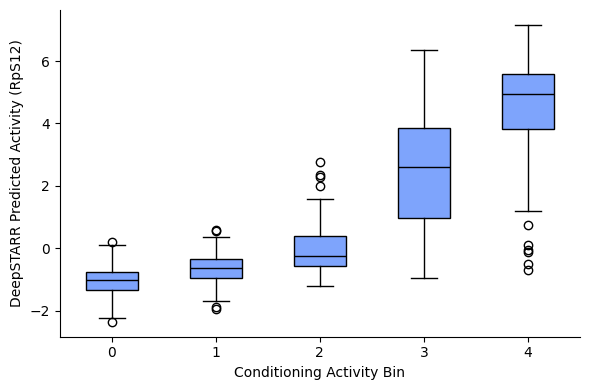

In [9]:
# 📊 Visualize Experiment 1 Results
fig, ax = plt.subplots(figsize=(6, 4))

data = [RpS12_bin_pred[i][1].squeeze() for i in range(5)]  # RpS12 predictions (column 1)
bp = ax.boxplot(data, tick_labels=[str(i) for i in range(5)], patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('#7ea4fc')
    patch.set_edgecolor('black')
for median in bp['medians']:
    median.set_color('black')

ax.set_xlabel('Conditioning Activity Bin')
ax.set_ylabel('DeepSTARR Predicted Activity (RpS12)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### 🧪 Experiment 2: Promoter-Specific Enhancer Generation


In [10]:
# Generate DSCP-specific enhancers (high in DSCP, contrast against RpS12)
DSCP_enhancers = generate_enhancers_batch(
    model=model,
    tokenizer=tokenizer,
    species_dict=model.config.species_to_token_id,
    backbone_metadata=backbone_metadata,
    exp_promoter='DSCP',
    exp_activity=4,
    bg_promoter='RpS12',
    bg_activity=4,
    num_sequences=512,
    batch_size=8,
    num_steps=50,
    gamma=2.0,
    verbose=False
)

# Generate RpS12-specific enhancers (high in RpS12, contrast against DSCP)
RpS12_enhancers = generate_enhancers_batch(
    model=model,
    tokenizer=tokenizer,
    species_dict=model.config.species_to_token_id,
    backbone_metadata=backbone_metadata,
    exp_promoter='RpS12',
    exp_activity=4,
    bg_promoter='DSCP',
    bg_activity=4,
    num_sequences=512,
    batch_size=8,
    num_steps=50,
    gamma=2.0,
    verbose=False
)

In [11]:
# Evaluate Experiment 2 sequences with DeepSTARR
# DeepSTARR outputs: [DSCP activity, RpS12 activity]

rps12_onehot = one_hot_tokenizer(RpS12_enhancers)
dscp_onehot = one_hot_tokenizer(DSCP_enhancers)

rps12_pred = deepstarr_model.predict(rps12_onehot, batch_size=32, verbose=0)
dscp_pred = deepstarr_model.predict(dscp_onehot, batch_size=32, verbose=0)

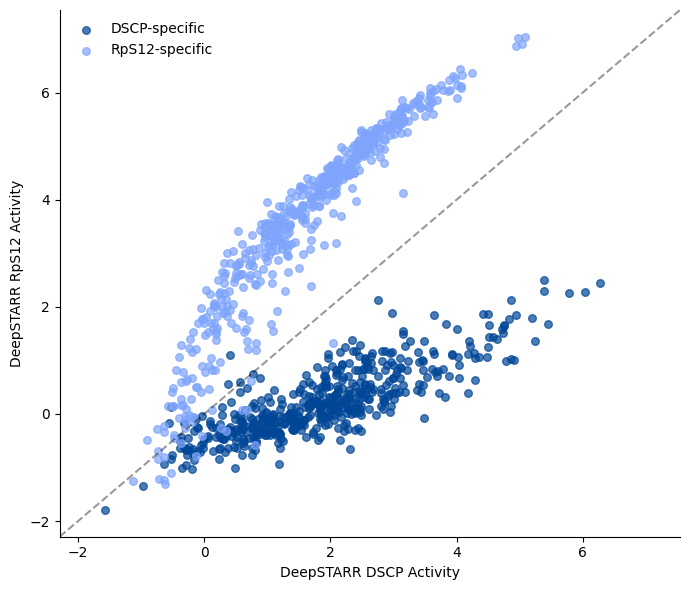

In [12]:
# 📊 Visualize Experiment 2 Results
DSCP_COLOR = '#004697'   # Deep blue for developmental
HK_COLOR = '#7ea4fc'     # Light blue for housekeeping

fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(dscp_pred[0].squeeze(), dscp_pred[1].squeeze(), color=DSCP_COLOR, alpha=0.7, s=30, label='DSCP-specific')
ax.scatter(rps12_pred[0].squeeze(), rps12_pred[1].squeeze(), color=HK_COLOR, alpha=0.7, s=30, label='RpS12-specific')

# Diagonal reference line (y=x)
all_vals = np.concatenate([dscp_pred, rps12_pred])
lim_min, lim_max = all_vals.min() - 0.5, all_vals.max() + 0.5
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', alpha=0.4)

ax.set_xlim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)
ax.set_xlabel('DeepSTARR DSCP Activity')
ax.set_ylabel('DeepSTARR RpS12 Activity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', frameon=False)
plt.tight_layout()
plt.show()
